In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

print(tf.__version__)

2.8.0


In [2]:
path = '../../../project_data/data/fer_data.csv'
df = pd.read_csv(path)
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [3]:
df.columns

Index(['usage', 'emotion', 'pixels'], dtype='object')

In [4]:
df.usage.value_counts()

train    31432
test      7896
Name: usage, dtype: int64

In [5]:
df.groupby(['usage']).emotion.value_counts()

usage  emotion
test   3          1774
       4          1247
       6          1233
       2          1024
       0           957
       5           831
       1           830
train  3          7214
       6          4964
       4          4829
       2          4097
       0          3988
       1          3170
       5          3170
Name: emotion, dtype: int64

In [6]:
# creating a dataframe that only contains training data
train = df[df['usage']=='train'].copy()
# dropping the usage column
train.drop(['usage'], axis = 1, inplace = True)
train.reset_index(inplace = True, drop = True)
print(train.shape)
train.head()

(31432, 2)


,emotion,pixels
0,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [7]:
train.groupby(['emotion']).count()

,pixels
emotion,
0,3988
1,3170
2,4097
3,7214
4,4829
5,3170
6,4964


In [8]:
# creating a dataframe that only contains training data
test = df[df['usage']=='test'].copy()
# dropping the usage column
test.drop(['usage'], axis = 1, inplace = True)
test.reset_index(inplace = True, drop = True)
print(test.shape)
test.head()

(7896, 2)


,emotion,pixels
0,3,5 4 5 9 10 9 10 12 8 14 13 17 24 26 36 48 67 7...
1,3,19 21 22 18 20 21 16 18 19 18 20 23 23 14 16 1...
2,3,228 229 230 229 228 227 226 226 226 221 217 20...
3,3,25 33 43 30 46 84 105 118 139 142 145 146 148 ...
4,3,33 29 15 15 20 36 40 54 79 98 117 130 144 155 ...


In [9]:
test.groupby(['emotion']).count()

,pixels
emotion,
0,957
1,830
2,1024
3,1774
4,1247
5,831
6,1233


In [10]:
def get_pixels_and_scale(data):
    '''
    Function for extracting pixel values from the pixel column and scaling them between 0 and 1
    
    get values from the column|
    split on the whitespace
    convert to float16 datatype
    save as as numpy array
    scale the values between 0 and 1
    '''
    
    img_array = np.array(data.split(' '), dtype = 'float16')
    img_array = img_array / 255.0
    
    return img_array

def reshape_images(data):
    '''
    reshape pixels column into a (48,48,1)format
    return a numpy array
    '''

    reshaped_array = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    
    return reshaped_array

In [11]:
# extracting pixel values from the pixel column and scaling them between 0 and 1    
train['pixels'] = train['pixels'].apply(get_pixels_and_scale)
test['pixels'] = test['pixels'].apply(get_pixels_and_scale)


In [12]:
train.head()

,emotion,pixels
0,3,"[0.4236, 0.3254, 0.2471, 0.255, 0.349, 0.4353,..."
1,3,"[0.537, 0.5566, 0.6235, 0.6353, 0.6196, 0.5254..."
2,3,"[0.4353, 0.5806, 0.608, 0.655, 0.71, 0.749, 0...."
3,3,"[0.5923, 0.612, 0.4746, 0.392, 0.3137, 0.4548,..."
4,3,"[0.9727, 0.7334, 0.5845, 0.51, 0.3804, 0.549, ..."


In [13]:
test.head()

,emotion,pixels
0,3,"[0.0196, 0.01569, 0.0196, 0.0353, 0.0392, 0.03..."
1,3,"[0.0745, 0.08234, 0.0863, 0.0706, 0.0784, 0.08..."
2,3,"[0.894, 0.898, 0.902, 0.898, 0.894, 0.89, 0.88..."
3,3,"[0.098, 0.1294, 0.1686, 0.1177, 0.1804, 0.3293..."
4,3,"[0.1294, 0.1137, 0.05884, 0.05884, 0.0784, 0.1..."


In [14]:
test.iloc[0,1].shape

(2304,)

In [15]:
X_train = reshape_images(train)
y_train = train['emotion'].to_numpy()

X_test = reshape_images(test)
y_test = test['emotion'].to_numpy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31432, 48, 48, 1) (31432,)
(7896, 48, 48, 1) (7896,)


## KERAS

## image Augmentation

In [119]:
traingen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

traingen.fit(X_train)
train_batch = 1024
traingen = traingen.flow(X_train, y_train, batch_size=train_batch)

testgen = ImageDataGenerator()
test_batch = 256
testgen = testgen.flow(X_test, y_test, batch_size=test_batch)

In [102]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy')>0.95):
#             print("\nReached 95% accuracy so cancelling training!")
#             self.model.stop_training = True
# callbacks=myCallback()

## Base Model
### 8s Per epoch, 52.05% val accuracy

In [81]:
# added dropout layers between dense ones
mdl11_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax')
])

mdl11_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

callbacks=myCallback()


traingen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

traingen.fit(X_train)
train_batch=1024
traingen = traingen.flow(X_train, y_train, batch_size=train_batch)

testgen = ImageDataGenerator()
test_batch=256
testgen = testgen.flow(X_test, y_test, batch_size=test_batch)

history_mdl11_1 = mdl11_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs=50,
      steps_per_epoch=31,
      validation_steps=31,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/50


2022-05-18 14:11:53.772515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 1.9176 - accuracy: 0.2284

2022-05-18 14:12:01.933109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 9s 269ms/step - loss: 1.9176 - accuracy: 0.2284 - val_loss: 1.9143 - val_accuracy: 0.2247
Epoch 2/50
31/31 [==============================] - 8s 267ms/step - loss: 1.9046 - accuracy: 0.2296 - val_loss: 1.8949 - val_accuracy: 0.2295
Epoch 3/50
31/31 [==============================] - 8s 260ms/step - loss: 1.8964 - accuracy: 0.2310 - val_loss: 1.8901 - val_accuracy: 0.2304
Epoch 4/50
31/31 [==============================] - 8s 259ms/step - loss: 1.8903 - accuracy: 0.2305 - val_loss: 1.8790 - val_accuracy: 0.2301
Epoch 5/50
31/31 [==============================] - 8s 264ms/step - loss: 1.8853 - accuracy: 0.2319 - val_loss: 1.8810 - val_accuracy: 0.2351
Epoch 6/50
31/31 [==============================] - 8s 258ms/step - loss: 1.8794 - accuracy: 0.2339 - val_loss: 1.8486 - val_accuracy: 0.2453
Epoch 7/50
31/31 [==============================] - 8s 261ms/step - loss: 1.8709 - accuracy: 0.2395 - val_loss: 1.8335 - val_accuracy: 0.2663
Epoch 8/50
31/31 

In [76]:
def plot_model_accuracy(fitted_model):
    '''
    Function visualizing comparison of 
    training and validaton loss and accuracy
    
    '''
    
    fig , ax = plt.subplots(1,2)
    train_acc = fitted_model.history['accuracy']
    train_loss = fitted_model.history['loss']
    fig.set_size_inches(15,4)

    ax[0].plot(fitted_model.history['accuracy'])
    ax[0].plot(fitted_model.history['val_accuracy'])
    ax[0].set_title('Training vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(fitted_model.history['loss'])
    ax[1].plot(fitted_model.history['val_loss'])
    ax[1].set_title('Training vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='lower left')

    plt.show()

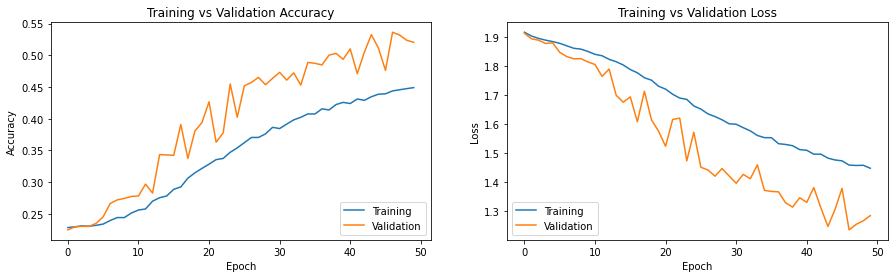

In [82]:
plot_model_accuracy(history_mdl11_1)

In [118]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl11_1.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))
# print("test loss, test acc:", results)

Evaluate on test data
62/62 [==============================] - 1s 12ms/step - loss: 1.2858 - accuracy: 0.5205
test_loss, test_acc:  1.2858 52.0517


# L1 Kernel & Bias Regularization: gets stuck at 22.47% val_accuracy
as seen here https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md

In [92]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy')>0.95):
#             print("\nReached 95% accuracy so cancelling training!")
#             self.model.stop_training = True
                 
# callbacks=myCallback()

In [97]:
#checkpoint to save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

# define number of epochs with no improvement after which training will be stopped
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='max')

#define callbacks
callbacks = [earlystop, checkpoint]

Epoch 1/50


2022-05-18 16:08:34.850830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 16.4741 - accuracy: 0.2279

2022-05-18 16:08:43.130599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 10s 280ms/step - loss: 16.4741 - accuracy: 0.2279 - val_loss: 12.1143 - val_accuracy: 0.2247
Epoch 2/50
30/30 [==============================] - 8s 267ms/step - loss: 9.4016 - accuracy: 0.2295 - val_loss: 6.9937 - val_accuracy: 0.2247
Epoch 3/50
30/30 [==============================] - 8s 269ms/step - loss: 5.5852 - accuracy: 0.2295 - val_loss: 4.3527 - val_accuracy: 0.2247
Epoch 4/50
30/30 [==============================] - 8s 265ms/step - loss: 3.5469 - accuracy: 0.2295 - val_loss: 2.8603 - val_accuracy: 0.2247
Epoch 5/50
30/30 [==============================] - 8s 263ms/step - loss: 2.4588 - accuracy: 0.2295 - val_loss: 2.1775 - val_accuracy: 0.2247
Epoch 6/50
30/30 [==============================] - 8s 267ms/step - loss: 2.1206 - accuracy: 0.2295 - val_loss: 2.1093 - val_accuracy: 0.2247


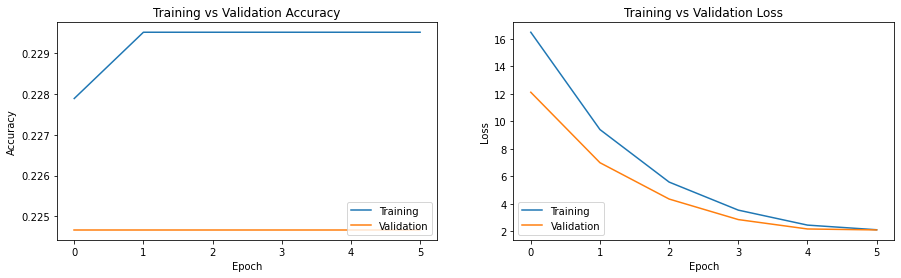

In [104]:
# added L1 regularization
mdl12_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           kernel_regularizer=regularizers.L1(1e-3),
                           bias_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L1(1e-3), 
                           bias_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L1(1e-3),
                           bias_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L1(1e-3),
                           bias_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.L1(1e-3),
                          bias_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=regularizers.L1(1e-3),
                          bias_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          kernel_regularizer=regularizers.L1(1e-3),
                          bias_regularizer=regularizers.L1(1e-3))
])

mdl12_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl12_1 = mdl12_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl12_1)

## L1 Activity Regularization: gets stuck at 22.47% val_accuracy

Epoch 1/50


2022-05-18 16:15:58.023911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 3.4712 - accuracy: 0.2282 - sparse_categorical_crossentropy: 1.9162

2022-05-18 16:16:10.388232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 14s 420ms/step - loss: 3.4712 - accuracy: 0.2282 - sparse_categorical_crossentropy: 1.9162 - val_loss: 2.9712 - val_accuracy: 0.2247 - val_sparse_categorical_crossentropy: 1.9118
Epoch 2/50
30/30 [==============================] - 13s 405ms/step - loss: 2.2572 - accuracy: 0.2295 - sparse_categorical_crossentropy: 1.9081 - val_loss: 2.0697 - val_accuracy: 0.2247 - val_sparse_categorical_crossentropy: 1.9116
Epoch 3/50
30/30 [==============================] - 12s 395ms/step - loss: 1.9508 - accuracy: 0.2295 - sparse_categorical_crossentropy: 1.9081 - val_loss: 1.9430 - val_accuracy: 0.2247 - val_sparse_categorical_crossentropy: 1.9115
Epoch 4/50
30/30 [==============================] - 12s 402ms/step - loss: 1.9215 - accuracy: 0.2295 - sparse_categorical_crossentropy: 1.9081 - val_loss: 1.9244 - val_accuracy: 0.2247 - val_sparse_categorical_crossentropy: 1.9117
Epoch 5/50
30/30 [==============================] - 12s 398ms/step - loss: 1.9151 - acc

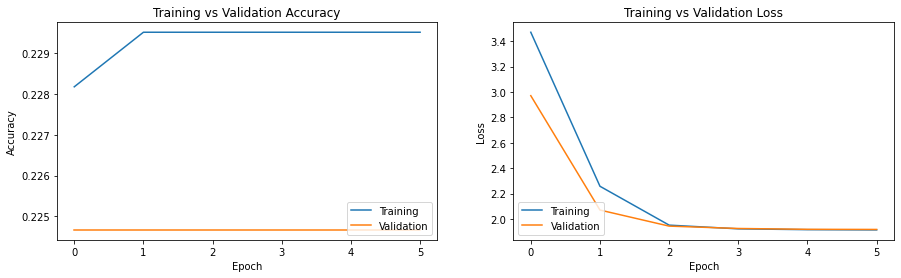

In [108]:
mdl13_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L1(1e-3))
])

mdl13_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy','sparse_categorical_crossentropy'])

history_mdl13_1 = mdl13_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl13_1)

## Removing regularizer from the last layer: gets stuck at 22.47% val_accuracy

Epoch 1/50


2022-05-18 16:17:51.974792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 3.4628 - accuracy: 0.2281

2022-05-18 16:18:04.382535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 14s 420ms/step - loss: 3.4628 - accuracy: 0.2281 - val_loss: 2.9713 - val_accuracy: 0.2247
Epoch 2/50
30/30 [==============================] - 12s 394ms/step - loss: 2.2557 - accuracy: 0.2295 - val_loss: 2.0686 - val_accuracy: 0.2247
Epoch 3/50
30/30 [==============================] - 12s 386ms/step - loss: 1.9501 - accuracy: 0.2295 - val_loss: 1.9420 - val_accuracy: 0.2247
Epoch 4/50
30/30 [==============================] - 12s 380ms/step - loss: 1.9204 - accuracy: 0.2295 - val_loss: 1.9228 - val_accuracy: 0.2247
Epoch 5/50
30/30 [==============================] - 12s 381ms/step - loss: 1.9137 - accuracy: 0.2295 - val_loss: 1.9168 - val_accuracy: 0.2247
Epoch 6/50
30/30 [==============================] - 12s 375ms/step - loss: 1.9121 - accuracy: 0.2295 - val_loss: 1.9156 - val_accuracy: 0.2247


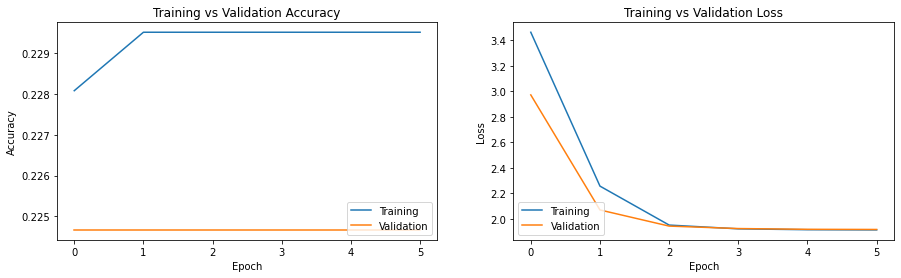

In [109]:
mdl14_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L1(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax')
])

mdl14_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl14_1 = mdl14_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl14_1)

## L2 Kernel & Bias: gets stuck at 22.47% val_accuracy

Epoch 1/50


2022-05-18 16:20:26.718005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.6218 - accuracy: 0.2271

2022-05-18 16:20:35.756860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 11s 310ms/step - loss: 2.6218 - accuracy: 0.2271 - val_loss: 2.4310 - val_accuracy: 0.2247
Epoch 2/50
30/30 [==============================] - 8s 270ms/step - loss: 2.3100 - accuracy: 0.2295 - val_loss: 2.2036 - val_accuracy: 0.2247
Epoch 3/50
30/30 [==============================] - 8s 271ms/step - loss: 2.1260 - accuracy: 0.2295 - val_loss: 2.0612 - val_accuracy: 0.2247
Epoch 4/50
30/30 [==============================] - 8s 265ms/step - loss: 2.0167 - accuracy: 0.2295 - val_loss: 1.9798 - val_accuracy: 0.2247
Epoch 5/50
30/30 [==============================] - 8s 265ms/step - loss: 1.9599 - accuracy: 0.2291 - val_loss: 1.9431 - val_accuracy: 0.2247
Epoch 6/50
30/30 [==============================] - 8s 269ms/step - loss: 1.9337 - accuracy: 0.2300 - val_loss: 1.9283 - val_accuracy: 0.2247


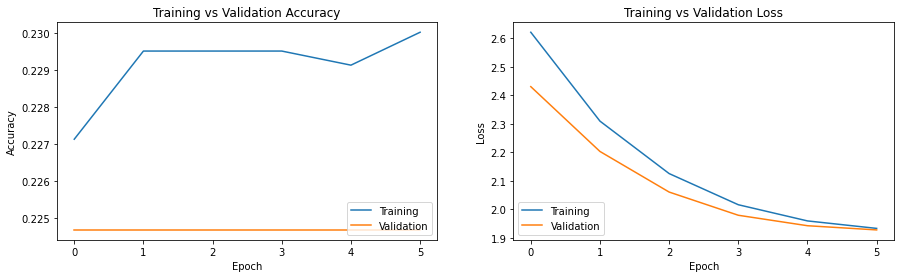

In [110]:
mdl15_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           kernel_regularizer=regularizers.L2(1e-3),
                           bias_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L2(1e-3), 
                           bias_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L2(1e-3),
                           bias_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L2(1e-3),
                           bias_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.L2(1e-3),
                          bias_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=regularizers.L2(1e-3),
                          bias_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          kernel_regularizer=regularizers.L2(1e-3),
                          bias_regularizer=regularizers.L2(1e-3))
])

mdl15_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl15_1 = mdl15_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl15_1)

## L2 Activity: significantly slows down training but gives better result
### 12-20s per epoch // 53.22% val accuracy after 50 epocs
### vs 8s Per epoch, 52.05% val accuracy of the base model

Epoch 1/50


2022-05-18 16:22:56.106367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.1332 - accuracy: 0.2284 - sparse_categorical_crossentropy: 1.9112

2022-05-18 16:23:08.377768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 14s 404ms/step - loss: 2.1332 - accuracy: 0.2284 - sparse_categorical_crossentropy: 1.9112 - val_loss: 2.0402 - val_accuracy: 0.2247 - val_sparse_categorical_crossentropy: 1.9077
Epoch 2/50
30/30 [==============================] - 12s 382ms/step - loss: 1.9412 - accuracy: 0.2313 - sparse_categorical_crossentropy: 1.8965 - val_loss: 1.9337 - val_accuracy: 0.2247 - val_sparse_categorical_crossentropy: 1.9078
Epoch 3/50
30/30 [==============================] - 12s 397ms/step - loss: 1.9002 - accuracy: 0.2285 - sparse_categorical_crossentropy: 1.8907 - val_loss: 1.9102 - val_accuracy: 0.2077 - val_sparse_categorical_crossentropy: 1.9015
Epoch 4/50
30/30 [==============================] - 13s 423ms/step - loss: 1.8931 - accuracy: 0.2298 - sparse_categorical_crossentropy: 1.8877 - val_loss: 1.8832 - val_accuracy: 0.2321 - val_sparse_categorical_crossentropy: 1.8767
Epoch 5/50
30/30 [==============================] - 12s 390ms/step - loss: 1.8880 - acc

30/30 [==============================] - 23s 736ms/step - loss: 1.5566 - accuracy: 0.4083 - sparse_categorical_crossentropy: 1.5444 - val_loss: 1.3539 - val_accuracy: 0.5039 - val_sparse_categorical_crossentropy: 1.3322
Epoch 37/50
30/30 [==============================] - 23s 747ms/step - loss: 1.5478 - accuracy: 0.4095 - sparse_categorical_crossentropy: 1.5356 - val_loss: 1.3454 - val_accuracy: 0.5001 - val_sparse_categorical_crossentropy: 1.3241
Epoch 38/50
30/30 [==============================] - 24s 765ms/step - loss: 1.5282 - accuracy: 0.4197 - sparse_categorical_crossentropy: 1.5156 - val_loss: 1.3521 - val_accuracy: 0.5053 - val_sparse_categorical_crossentropy: 1.3313
Epoch 39/50
30/30 [==============================] - 23s 745ms/step - loss: 1.5251 - accuracy: 0.4221 - sparse_categorical_crossentropy: 1.5123 - val_loss: 1.3919 - val_accuracy: 0.4847 - val_sparse_categorical_crossentropy: 1.3706
Epoch 40/50
30/30 [==============================] - 22s 710ms/step - loss: 1.5146 -

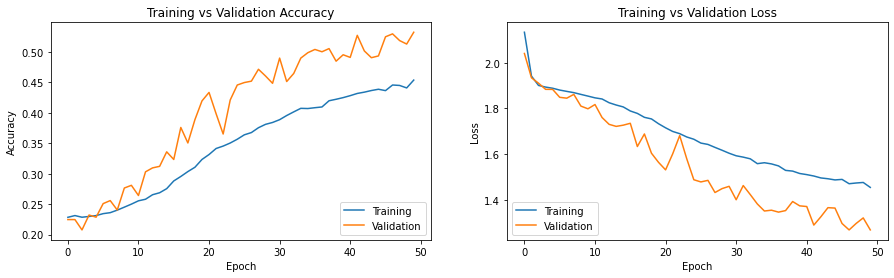

In [111]:
mdl16_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl16_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy','sparse_categorical_crossentropy'])

history_mdl16_1 = mdl16_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_1)

In [121]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# test_loss, test_acc = mdl16_1.evaluate(X_test, y_test, batch_size=128)
result = mdl16_1.evaluate(X_test, y_test, batch_size=128)
# print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

Evaluate on test data
62/62 [==============================] - 1s 16ms/step - loss: 1.2676 - accuracy: 0.5322 - sparse_categorical_crossentropy: 1.2447


## L1L2 Kernel & Bias: gets stuck at 22.95% validation accuracy

Epoch 1/50


2022-05-18 16:48:39.036020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 17.1135 - accuracy: 0.2265

2022-05-18 16:48:48.475727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 11s 293ms/step - loss: 17.1135 - accuracy: 0.2265 - val_loss: 12.5516 - val_accuracy: 0.2247
Epoch 2/50
30/30 [==============================] - 8s 266ms/step - loss: 9.6915 - accuracy: 0.2295 - val_loss: 7.2162 - val_accuracy: 0.2247
Epoch 3/50
30/30 [==============================] - 8s 266ms/step - loss: 5.7430 - accuracy: 0.2295 - val_loss: 4.4581 - val_accuracy: 0.2247
Epoch 4/50
30/30 [==============================] - 8s 266ms/step - loss: 3.6258 - accuracy: 0.2295 - val_loss: 2.9080 - val_accuracy: 0.2247
Epoch 5/50
30/30 [==============================] - 8s 264ms/step - loss: 2.4914 - accuracy: 0.2295 - val_loss: 2.1922 - val_accuracy: 0.2247
Epoch 6/50
30/30 [==============================] - 8s 260ms/step - loss: 2.1254 - accuracy: 0.2295 - val_loss: 2.1110 - val_accuracy: 0.2247


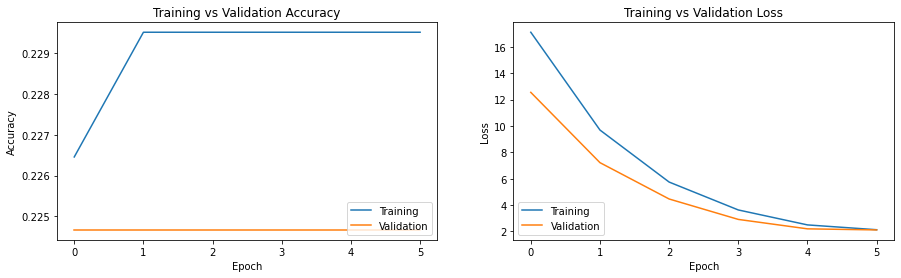

In [122]:
mdl17_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3),
                           bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3), 
                           bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3),
                           bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3),
                           bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3),
                          bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3),
                          bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          kernel_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3),
                          bias_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3))
])

mdl17_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl17_1 = mdl17_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl17_1)

## L1L2 Activity: gets stuck at 22.95% validation accuracy

Epoch 1/50


2022-05-18 16:50:53.430724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 3.7108 - accuracy: 0.2279

2022-05-18 16:51:08.414491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 17s 499ms/step - loss: 3.7108 - accuracy: 0.2279 - val_loss: 3.1298 - val_accuracy: 0.2247
Epoch 2/50
30/30 [==============================] - 15s 479ms/step - loss: 2.3160 - accuracy: 0.2295 - val_loss: 2.1049 - val_accuracy: 0.2247
Epoch 3/50
30/30 [==============================] - 15s 473ms/step - loss: 1.9598 - accuracy: 0.2295 - val_loss: 1.9461 - val_accuracy: 0.2247
Epoch 4/50
30/30 [==============================] - 14s 468ms/step - loss: 1.9227 - accuracy: 0.2295 - val_loss: 1.9250 - val_accuracy: 0.2247
Epoch 5/50
30/30 [==============================] - 15s 476ms/step - loss: 1.9151 - accuracy: 0.2295 - val_loss: 1.9182 - val_accuracy: 0.2247
Epoch 6/50
30/30 [==============================] - 15s 474ms/step - loss: 1.9131 - accuracy: 0.2295 - val_loss: 1.9169 - val_accuracy: 0.2247


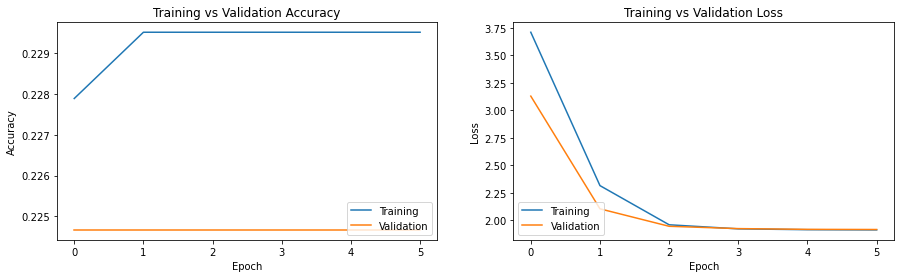

In [123]:
mdl18_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L1L2(l1=1e-3,l2=1e-3))
])

mdl18_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl18_1 = mdl18_1.fit(
      train_datagen,
      validation_data = valid_datagen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl18_1)

## Testing model 16_1 longer

In [16]:
# creating generators for image augmentation
traingen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

traingen.fit(X_train)
train_batch = 1024
traingen = traingen.flow(X_train, y_train, batch_size=train_batch)

testgen = ImageDataGenerator()
test_batch = 256
testgen = testgen.flow(X_test, y_test, batch_size=test_batch)

#checkpoint to save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

# define number of epochs with no improvement after which training will be stopped
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=10,
                          mode='max')

#define callbacks
callbacks = [earlystop, checkpoint]

In [19]:
mdl16_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl16_2.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl16_2 = mdl16_2.fit(
      traingen,
      validation_data = testgen,  
      epochs = 50,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_test)/test_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_2)

Metal device set to: Apple M1


2022-05-18 22:40:03.319296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 22:40:03.319434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2022-05-18 22:40:03.586890: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-18 22:40:04.080032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.3229 - accuracy: 0.2256

2022-05-18 22:40:16.657637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 14s 423ms/step - loss: 2.3229 - accuracy: 0.2256 - val_loss: 2.2340 - val_accuracy: 0.2247
Epoch 2/50
30/30 [==============================] - 12s 398ms/step - loss: 2.0418 - accuracy: 0.2308 - val_loss: 2.0137 - val_accuracy: 0.2252
Epoch 3/50
30/30 [==============================] - 13s 435ms/step - loss: 1.9391 - accuracy: 0.2302 - val_loss: 1.9176 - val_accuracy: 0.2280
Epoch 4/50
30/30 [==============================] - 12s 393ms/step - loss: 1.9006 - accuracy: 0.2305 - val_loss: 1.8873 - val_accuracy: 0.2321
Epoch 5/50
30/30 [==============================] - 12s 402ms/step - loss: 1.8885 - accuracy: 0.2308 - val_loss: 1.8769 - val_accuracy: 0.2299
Epoch 6/50
30/30 [==============================] - 13s 430ms/step - loss: 1.8796 - accuracy: 0.2340 - val_loss: 1.8507 - val_accuracy: 0.2566
Epoch 7/50
30/30 [==============================] - 14s 442ms/step - loss: 1.8720 - accuracy: 0.2361 - val_loss: 1.8510 - val_accuracy: 0.2530
Epoch 8/50

KeyboardInterrupt: 